In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2
%matplotlib inline

Using TensorFlow backend.


In [2]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [3]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [4]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_val.shape,y_val.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)
(4410, 32, 32, 3) (4410,)


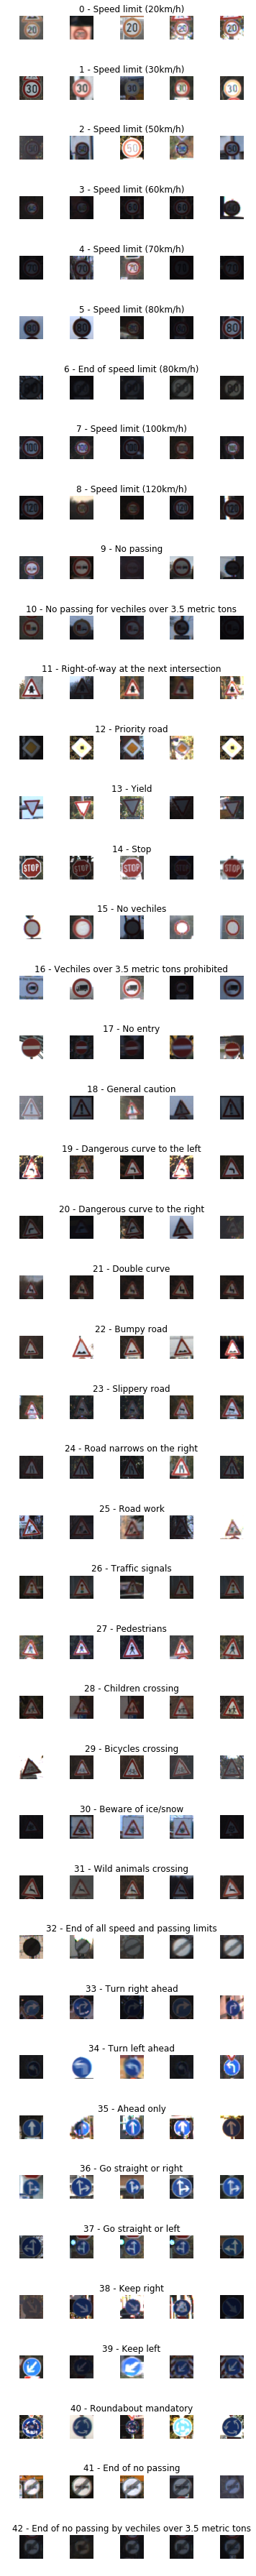

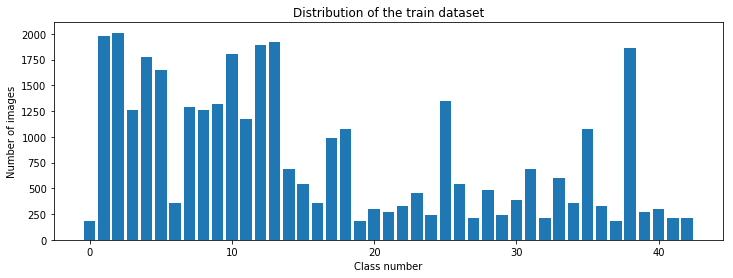

In [5]:
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
num_of_samples=[]
for i in range(cols):
      for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
              axs[j][i].set_title(str(j) + " - " + row["SignName"])
              num_of_samples.append(len(x_selected))
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32)


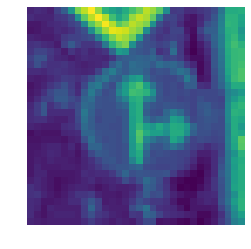

In [6]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


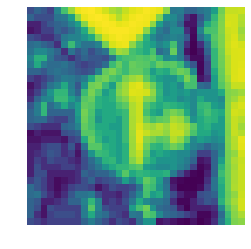

In [7]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [8]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [9]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

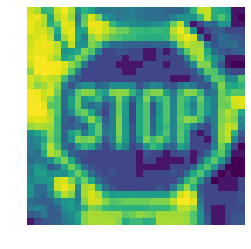

In [10]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off');

In [11]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


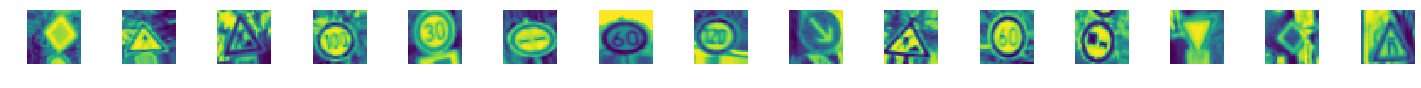

In [12]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)


datagen.fit(X_train)

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 12))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [13]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [14]:
def modified_model():
    model = Sequential([
    Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'),
    Conv2D(60, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
 
    Conv2D(30, (3, 3), activation='relu'),
    Conv2D(30, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax'),
    ])   
    return model

In [15]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

In [16]:
model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 41s 21ms/step - loss: 0.9400 - acc: 0.7245 - val_loss: 0.0956 - val_acc: 0.9705
Epoch 2/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.2351 - acc: 0.9264 - val_loss: 0.0652 - val_acc: 0.9825
Epoch 3/10
2000/2000 [==============================] - 35s 17ms/step - loss: 0.1545 - acc: 0.9518 - val_loss: 0.0489 - val_acc: 0.9844
Epoch 4/10
2000/2000 [==============================] - 35s 17ms/step - loss: 0.1217 - acc: 0.9622 - val_loss: 0.0330 - val_acc: 0.9896
Epoch 5/10
2000/2000 [==============================] - 35s 17ms/step - loss: 0.0999 - acc: 0.9697 - val_loss: 0.0459 - val_acc: 0.9873
Epoch 6/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.0889 - acc: 0.9724 - val_loss: 0.0316 - val_acc: 0.9912
Epoch 7/10
2000/2000 [==============================] - 35s 18ms/step - loss: 0.0790 - acc: 0.9756 - val_loss: 0.0370 - val_acc: 0.9891
Epoch 8/10
2000/2000 [==========================

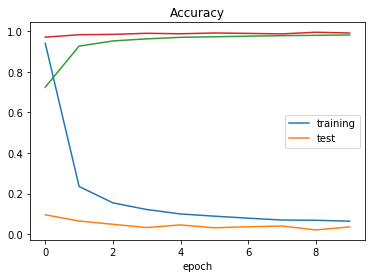

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch');

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14026718424077833
Test accuracy: 0.9695961995438178


predicted sign: [33]


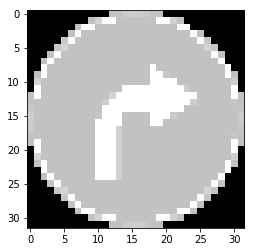

In [20]:
import requests
from PIL import Image
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Korean_Traffic_sign_%28Right_Turn%29.svg/395px-Korean_Traffic_sign_%28Right_Turn%29.svg.png'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
img = img.reshape(1, 32, 32, 1)

print("predicted sign: "+ str(model.predict_classes(img)))